In [62]:
import re
import random
import pandas as pd
import hashlib

In [63]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate', 'Jane Eyre, Bronte']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [64]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Pandas,304.898199,33.877578,51.357683,9
CCH Axcess,378.684212,13.058076,25.882546,29
DAX,507.850552,56.427839,136.174256,9
"Jane Eyre, Bronte",523.642219,74.806031,174.692097,7
Logging in Python,606.110485,75.763811,212.068650,8
Azure Private DNS,763.627302,84.847478,187.334013,9
Terraform,1006.482048,83.873504,265.806513,12
Azure AD Authentication,1166.157388,97.179782,155.655272,12
Microsoft Purview,1311.353009,27.319854,46.056303,48
Azure Functions + PP365,1356.474748,84.779672,242.638362,16


# Histogram

sum of ages: ~50325.32


<Axes: >

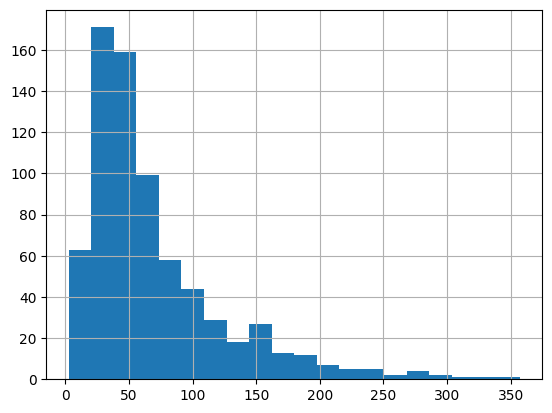

In [65]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~50325.32


<Axes: >

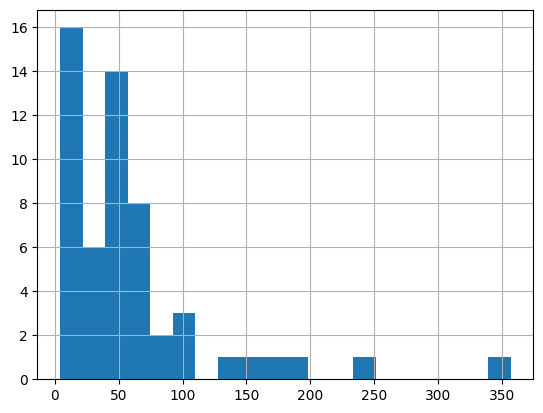

In [66]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Developer Associate']['age'].hist(bins=20)

# Completely Random Shuffle

In [67]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [68]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [69]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [70]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [71]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [72]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [73]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [74]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [75]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [76]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [77]:
n=10
existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'frequency', 'subject_highest_age', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 721
Total card age: 50325.32


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,frequency,count,n_fold,neg_age
194,"Jane Eyre, Bronte",Contumelious Epithet\n(con-too-MEE-lee-uhs EP-...,207dabac7e5cf26508c489cd7c97d38d,174.692097,74.806031,174.692097,523.642219,0.343159,7,7,0,0,-174.692097
437,"Jane Eyre, Bronte",Salubrious\n(suh-LOO-bree-uhs) Describing some...,a4e97a6bcfb2423b479db36526595e42,121.990696,74.806031,174.692097,523.642219,0.343159,7,7,1,0,-121.990696
674,"Jane Eyre, Bronte",Basin and Ewer\n(BAY-sin and YOO-er) A bowl (b...,a985a5826fd5d734c4090f3f9d253305,85.902803,74.806031,174.692097,523.642219,0.343159,7,7,2,0,-85.902803
195,"Jane Eyre, Bronte","Cachinnation (kak-ih-NAY-shun)\nLoud, uncontro...",5a55925ded4db77d8d93e5fc0dd1655c,62.342728,74.806031,174.692097,523.642219,0.343159,7,7,3,0,-62.342728
438,"Jane Eyre, Bronte","Beldame\n(BEL-dame) An old woman, sometimes us...",d01e1e360b6b8ae184786b5c649e3009,58.100664,74.806031,174.692097,523.642219,0.343159,7,7,4,0,-58.100664
675,"Jane Eyre, Bronte",Hips and Haws\nFruits of wild roses (hips) and...,f8b6dfd9eece8b9d0bdfc49feed71965,11.046998,74.806031,174.692097,523.642219,0.343159,7,7,5,0,-11.046998
196,"Jane Eyre, Bronte",Fillip\n(FIL-ip) A small but impactful boost o...,4a62d364c2b7af68b752dda31c131779,9.566233,74.806031,174.692097,523.642219,0.343159,7,7,6,0,-9.566233
168,Logging in Python,Q: What is the purpose of a Formatter in Pytho...,17418e042ab1749edb701aa3bc7ea3f1,212.068650,75.763811,212.068650,606.110485,0.086227,8,8,0,0,-212.068650
412,Logging in Python,Q: What is the significance of the level param...,ab5284fc921e39859fdd6d762eb8cd19,149.404946,75.763811,212.068650,606.110485,0.086227,8,8,1,0,-149.404946
650,Logging in Python,Q: What is one advantage of using structured l...,ebb66e6f4db8458145e17418ea69a3b5,68.232362,75.763811,212.068650,606.110485,0.086227,8,8,2,0,-68.232362



## Random

In [78]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [79]:
if existing_cards.age.sum() < 0:
    asc = True
else: asc = False
existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,frequency,count,n_fold,neg_age
244,Azure Developer Associate,A company has an App Service web app that requ...,786eb611c1ad4b131a5b90871a4e2fd8,357.093344,59.731729,357.093344,3285.245098,0.409409,55,55,0,0,-357.093344
15,C# Basics,What’s the difference between delegates and ev...,aafda82832da4aaff149c8153e06fc0a,337.602339,89.305564,337.602339,2679.166919,0.399227,30,30,0,0,-337.602339
25,FSLogix,"Cloud Cache uses the concept of a proxy file, ...",78203bab9238f47ee752697bba4135a5,307.315434,88.635365,307.315434,2747.696314,0.923043,31,31,0,0,-307.315434
36,Asynchronous Python,asyncio.wait_for()\nRuns a coroutine with a ti...,0ccadcbce46e58eb4de4907f7e86cbf9,291.639292,88.831595,291.639292,3375.600618,0.912974,38,38,0,0,-291.639292
49,Azure DevOps Pipelines,What is the default working directory for a pi...,4874a140413af48140b5cb984340bd62,290.254790,100.567759,290.254790,1609.084140,0.419872,16,16,0,0,-290.254790
297,Azure DevOps Pipelines,How can you pass secrets securely in Azure Dev...,5b00153ed3bdf8955aa08ad4e2779a5c,285.100375,100.567759,290.254790,1609.084140,0.419872,16,16,1,0,-285.100375
284,Asynchronous Python,async with (async context manager)\nManages as...,359a45c84a774bead164891fd0454b3c,283.073702,88.831595,291.639292,3375.600618,0.912974,38,38,1,0,-283.073702
73,PowerShell Modules,Find-Module\n\nDefinition: Searches for module...,4441d462ea754e1bb6a659efa359382f,279.928331,91.298951,279.928331,2465.071683,0.278251,27,27,0,0,-279.928331
55,Python,Q:\nWhich itertools function can be used to cr...,e10c94072687976e9627c8fc187d9ea3,279.398710,56.961049,279.398710,3018.935619,0.180518,53,53,0,0,-279.398710
82,Terraform,You can create and use Terraform modules that ...,dee44c7482afdda345bd10bdad89f932,265.806513,83.873504,265.806513,1006.482048,0.820389,12,12,0,0,-265.806513


In [80]:
existing_cards['age'].mean()

69.79934084965188